In [1]:
# --- 1. Setup & Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 999)

# Modeling Libraries
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

# Linear Models
from sklearn.linear_model import Ridge, Lasso, ElasticNet

# Setup
%matplotlib inline
sns.set_style('whitegrid')

# --- 2. Load Processed Data ---
# We load the clean data we saved in the previous notebook
try:
    X_train = pd.read_csv('../data/processed/X_train.csv')
    X_test = pd.read_csv('../data/processed/X_test.csv')
    y_train = pd.read_csv('../data/processed/y_train.csv')
    test_ID = pd.read_csv('../data/processed/test_ID.csv')
    
    # Convert y_train back to a 1D array (series) for the models
    y_train = y_train['SalePrice']
    
    print("Data loaded successfully.")
    print(f"Train shape: {X_train.shape}")
    print(f"Test shape: {X_test.shape}")
except FileNotFoundError:
    print("Error: Processed data not found. Run notebook 01 first.")

Data loaded successfully.
Train shape: (1458, 347)
Test shape: (1459, 347)


In [3]:
# --- 3. Define Validation Strategy ---

# 1. Setup K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 2. Define a function to calculate RMSE using Cross-Validation
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, 
                                    scoring="neg_mean_squared_error", 
                                    cv=kf))
    return(rmse)

print("Validation function 'rmse_cv' defined.")

Validation function 'rmse_cv' defined.


In [4]:
# --- 4. Baseline Model (Ridge) ---

# Make a pipeline: Scale the data -> Apply Ridge Model
# alpha=1.0 is the default regularization strength. We'll tune it later.
ridge_model = make_pipeline(RobustScaler(), Ridge(alpha=1.0))

# Calculate the score
score = rmse_cv(ridge_model)

print(f"Ridge Regression Score: {score.mean():.4f} (std: {score.std():.4f})")

Ridge Regression Score: 0.1189 (std: 0.0095)


Lasso Regression Score: 0.1112 (std: 0.0076)

Total Features: 347
Features kept by Lasso: 120
Features dropped by Lasso: 227


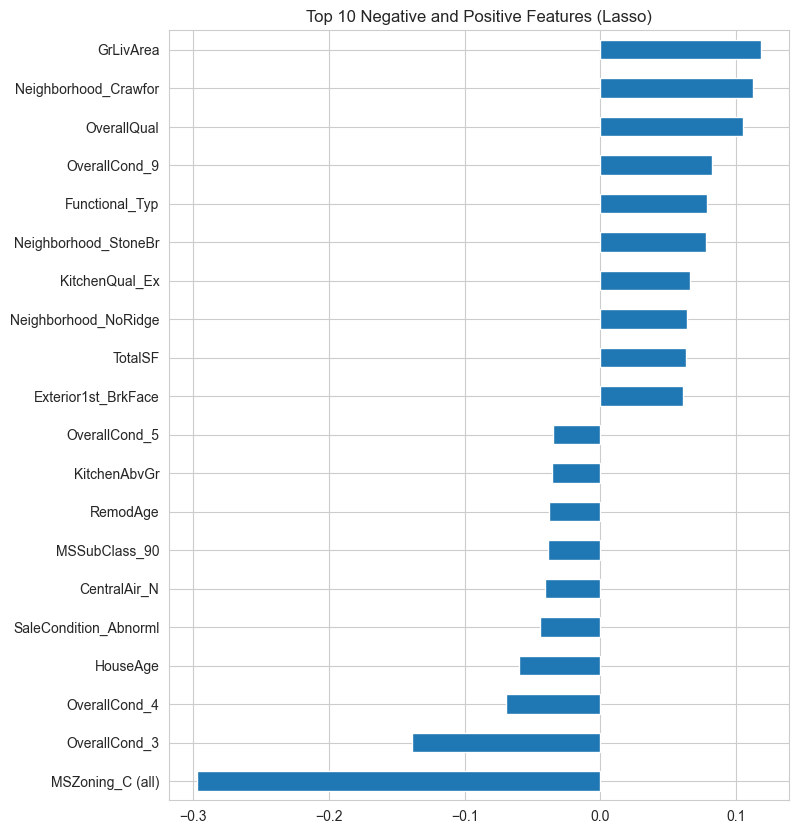

In [ ]:
# --- 5. Lasso Regression (Feature Selection) ---

# Lasso (L1 Regularization) forces weak features to have a coefficient of EXACTLY 0.
# we used fine tuning the hyperparameter alpha to find the best value for our dataset using grid searchcv
lasso_model = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))

score = rmse_cv(lasso_model)
print(f"Lasso Regression Score: {score.mean():.4f} (std: {score.std():.4f})")

# --- Visualize Feature Selection ---
# We need to fit the model to the data to see the coefficients
lasso_model.fit(X_train, y_train)

# Extract coefficients from the Lasso step of the pipeline
lasso_coef = pd.Series(lasso_model.steps[1][1].coef_, index=X_train.columns)

print(f"\nTotal Features: {len(X_train.columns)}")
print(f"Features kept by Lasso: {sum(lasso_coef != 0)}")
print(f"Features dropped by Lasso: {sum(lasso_coef == 0)}")

# Plot the most important features
plt.figure(figsize=(8, 10))
pd.concat([lasso_coef.sort_values().head(10), 
           lasso_coef.sort_values().tail(10)]).plot(kind="barh")
plt.title("Top 10 Negative and Positive Features (Lasso)")
plt.show()

In [ ]:
# --- 6. XGBoost Model (Non-Linear) ---
import xgboost as xgb

# Define the XGBoost Regressor
#thee parameters were found after a long process of tuning in google colab using dridsearchcv
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, random_state=7, n_jobs=-1)

# Evaluate with CV
score = rmse_cv(model_xgb)
print(f"XGBoost Score: {score.mean():.4f} (std: {score.std():.4f})")

XGBoost Score: 0.1169 (std: 0.0053)


In [ ]:
# --- 7. Final Training & Prediction ---

print("Training final models on the complete dataset...")

# 1. Train Lasso on all data
lasso_model.fit(X_train, y_train)
lasso_pred_log = lasso_model.predict(X_test)
print("Lasso training complete.")

# 2. Train XGBoost on all data
model_xgb.fit(X_train, y_train)
xgb_pred_log = model_xgb.predict(X_test)
print("XGBoost training complete.")

# 3. Blend Predictions (The Ensemble)

final_pred_log = (0.5 * lasso_pred_log) + (0.5 * xgb_pred_log)

# 4. Reverse the Log Transformation
#
final_pred = np.expm1(final_pred_log)

print("Predictions generated and transformed back to dollars.")

Training final models on the complete dataset...
Lasso training complete.
XGBoost training complete.
Predictions generated and transformed back to dollars.


In [9]:
# --- 8. Save Submission ---

# Create a dataframe with ID and SalePrice
submission = pd.DataFrame({
    "Id": test_ID['Id'],
    "SalePrice": final_pred
})

# Save to CSV
submission.to_csv('../data/submission.csv', index=False)

print("Submission file saved to 'data/submission.csv'!")
print("Go upload this to Kaggle!")

Submission file saved to 'data/submission.csv'!
Go upload this to Kaggle!


In [ ]:
# --- 9. Save Trained Models ---
import joblib
import os

# 1. Create a 'models' directory
model_dir = '../models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# 2. Save the models
joblib.dump(lasso_model, f'{model_dir}/lasso_tuned.pkl')
joblib.dump(model_xgb, f'{model_dir}/xgboost.pkl')

print(f"Models saved successfully to {model_dir}")
print("You can now load them anytime using joblib.load('filename.pkl')")

NameError: name 'best_lasso_model' is not defined